# **EKF SLAM**
**reference**: https://www.ipb.uni-bonn.de/teaching/

## **Kalman Filter**
- 선형모델에 대한 Prediction (예측)과 Correction(수정)을 반복적으로 수행하여 최적의 상태를 추정하는 필터
- **Prediction**: 현재 상태와 모델을 이용하여 다음 step의 상태를 예측 (2~3)
- **Correction**: 현재 상태와 관측값을 이용하여 상태를 수정 (4~6)

<img src="./images/figure1.png" width="500px" title="figure1"/>

<img src="./images/figure2.png" width="500px" title="figure2"/>

### **Kalman filter example**
- **TODO**: 1차원 모델을 이용하여 칼만 필터 설계하기

<img src="./images/figure3.png" width="300px" title="figure3"><br/>

- w와 v는 각각 분산이 R과 Q를 만족하는 gaussian random noise
- 분산을 만족하는 random noise는 정규분포에 표준편차를 곱한 형태 (hint: cholesky decomposition)

- 결과 예시

<img src="./images/figure4.png" width="500px" title="figure4"/>

In [150]:
from operator import inv
import numpy as np
import matplotlib.pyplot as plt

def true_state(x, u):
    A = np.array([[0.7]])
    B = np.array([[1/np.sqrt(2)]])
    R = np.array([[0.5]])
    ##### TODO: 모션모델을 작성해서 true data를 output #####
    # guassian noise가 모델에 반영되도록 작성
    x=A@x+B@u+np.linalg.cholesky(R)*np.random.rand()
    x_p = x
    ########################################################
    return x_p

def observation_model(x):
    C = np.reshape(1, [1, 1])
    Q = np.reshape(0.15, [1, 1])
    ###### TODO: 관측모델을 작성하여 sensor data를 output #####
    # guassian noise가 모델에 반영되도록 작성
    z= C@x+np.linalg.cholesky(Q)*np.random.rand()
    
    ###########################################################
    return z

class kalman_filter():
    def __init__(self):
        # 칼만필터에 사용할 system 정의
        self.A = np.array([[0.7]])
        self.B = np.array([[1/np.sqrt(2)]])
        self.C = np.array([[1]])
        self.R = np.array([[0.5]])
        self.Q = np.array([[0.15]])

        # 칼만필터 초기 state와 covariance 정의
        self.x = np.zeros([len(self.A), 1])
        self.P = 10*np.eye(len(self.A))
    
    def prediction(self, x, P, u):
        ##### TODO: 칼만필터의 prediction 부분 구현 #####
        x=self.A@x+self.B@u
        P=self.A@P@(self.A.T)+self.R
        x_p = x
        P_p = P
        #################################################
        return x_p, P_p

    def correction(self, x, P, z):
        ##### TODO: 칼만필터의 correction 부분 구현 #####
        K = P@(self.C.T)@np.linalg.inv(self.C@P@(self.C.T)+self.Q)
        x = x+K@(z-self.C@x)
        P = (np.eye(1)-K@self.C)@P
        x_c = x
        P_c = P
        #################################################
        return x_c, P_c

    def update(self, x, P, u, z):
        x_p, P_p = self.prediction(x, P, u)
        x_c, P_c = self.correction(x_p, P_p, z)
        return x_p, P_p, x_c, P_c

kalman = kalman_filter()
x_list = []
x_true_list = []
z_list = []
x_true = np.reshape(0, [1, 1])

for i in range(100):
    u = np.reshape(10, [1, 1])
    # true data generation
    x_true = true_state(x_true, u)
    # sensor data generation
    z = observation_model(x_true)

    # kalman filter
    _, _, kalman.x, kalman.P = kalman.update(kalman.x, kalman.P, u, z)

    # for plotting
    x_true_list.append(x_true.flatten())
    x_list.append(kalman.x.flatten())
    z_list.append(z.flatten())

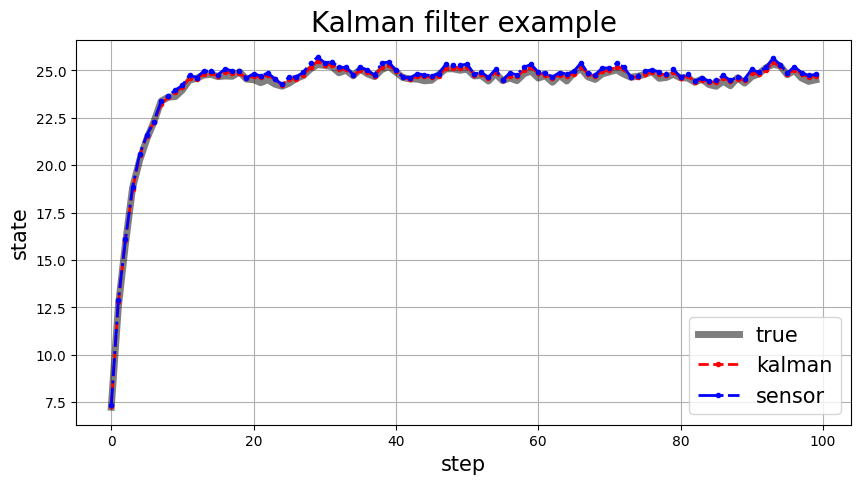

In [151]:
plt.figure(figsize=[10, 5], facecolor='w')
plt.plot(x_true_list, 'k-', linewidth=5, alpha=0.5)
plt.plot(x_list, 'r.--', linewidth=2)
plt.plot(z_list, 'b.-.', linewidth=2)
plt.grid('on')
plt.xlabel('step', fontsize=15)
plt.ylabel('state', fontsize=15)
plt.title('Kalman filter example', fontsize=20)
plt.legend(['true', 'kalman', 'sensor'], fontsize=15)
plt.show()

## **Extended Kalman Filter**
- 기존의 Kalman filter는 선형 모델에서만 적용가능
- 비선형 모델에서 칼만필터를 적용하기 위해서는 Taylor expansion을 이용한 선형화 과정이 필요

### **Taylor Expansion**
- 비선형 모델을 근사화를 통해 선형 모델로 표현하는 방법
- 선형화할 지점 근처에서는 합리적인 결과를 보임
- 보통 EKF에서는 1차 까지만 선형화하고 고차항은 무시

<img src="./images/figure5.png" width="500px" title="figure5"/>

<img src="./images/figure6.png" width="500px" title="figure6"/>

### **Jacobian Matrix**
- state가 2개 이상일 때, 각각의 state에 대해서 1차 편미분한 값을 matrix의 형태로 표현
- Jacobian matrix가 system matrix 대신 사용됨

<img src="./images/figure7.png" width="200px" title="figure7"/>

### **EKF formulation**
- 칼만필터와 거의 유사한 형태를 지니지만 A, C matrix 대신 Jacobian matrix 사용
- 평균값을 update 할 때는 비선형 모델을 그대로 사용
- Covariance를 update 할 때는 Jacobian matrix 사용

<img src="./images/figure8.png" width="500px" title="figure8"/>

#### **EKF example**
- **TODO**: 1차원 비선형 모델을 이용한 EKF 설계

<img align="left" src="./images/figure9.png" width="500px" title="figure9"/>

<img src="./images/figure10.png" width="500px" title="figure10"/>

In [152]:
import numpy as np
import matplotlib.pyplot as plt

def true_state(x, k):
    R = np.array([[0.5]])
    k = np.array([[k]])
    ##### TODO: 비선형 모션모델을 작성해서 true data를 output #####
    # guassian noise가 모델에 반영되도록 작성
    x_p = 0.5*x+25*x/(1+x**2)+8*np.cos(1.2*k)+np.linalg.cholesky(R)*np.random.rand()
    ########################################################
    return x_p

def observation_model(x):
    Q = np.reshape(0.15, [1, 1])
    ###### TODO: 비선형 관측모델을 작성하여 sensor data를 output #####
    # guassian noise가 모델에 반영되도록 작성
    z = (x**2)/20+np.linalg.cholesky(Q)*np.random.rand()
    ###########################################################
    return z

class extended_kalman_filter():
    def __init__(self):
        # 칼만필터에 사용할 system 정의
        self.R = np.array([[0.5]])
        self.Q = np.array([[0.15]])

        # 칼만필터 초기 state와 covariance 정의
        self.x = np.zeros([len(self.Q), 1])
        self.P = 10*np.eye(len(self.Q))

        # 현재 state를 바탕으로 Jacobian Matrix 계산
        self.G, self.H = self.Jacobian(self.x)

    def Jacobian(self, x):
        ###### TODO: 비선형 모델을 미분한 Jacobian matrix 작성 #####
        G = 0.5+25/(1+x**2)-50*x**2/((1+x**2)**2)
        # G = 0.5+25*(1-x**2)/((1+x**2)**2)
        H = 0.1*x

        H = x/10
        ######################################################
        return G, H
    
    def prediction(self, x, P, k):
        self.G, _ = self.Jacobian(x)
        ##### TODO: 칼만필터의 prediction 부분 구현 #####
        x_p = 0.5*x+25*x/(1+x**2)+8*np.cos(1.2*k)
        P_p = self.G@P@(self.G.T)+self.R
        #############################################
        return x_p, P_p

    def correction(self, x, P, z):
        _, self.H = self.Jacobian(x)
        ##### TODO: 칼만필터의 correction 부분 구현 #####
        
        K = P@(self.H.T)@np.linalg.inv(self.H@P@(self.H.T)+self.Q)
        x_c = x+K@(z-x**2/20)
        
        P_c = P-K@self.H@P
        ############################################
        return x_c, P_c
  
    def update(self, x, P, k, z):
        x_p, P_p = self.prediction(x, P, k)
        x_c, P_c = self.correction(x_p, P_p, z)
        return x_p, P_p, x_c, P_c

EKF = extended_kalman_filter()
x_list = []
x_true_list = []
z_list = []
x_true = np.reshape(0, [1, 1])

for i in range(100):
    # true data generation
    x_true = true_state(x_true, i)
    # sensor data generation
    z = observation_model(x_true)
   
    # kalman filter
    _, _, EKF.x, EKF.P = EKF.update(EKF.x, EKF.P, i, z)
    
    # plotting
    x_true_list.append(x_true.flatten())
    x_list.append(EKF.x.flatten())
    z_list.append(z.flatten())

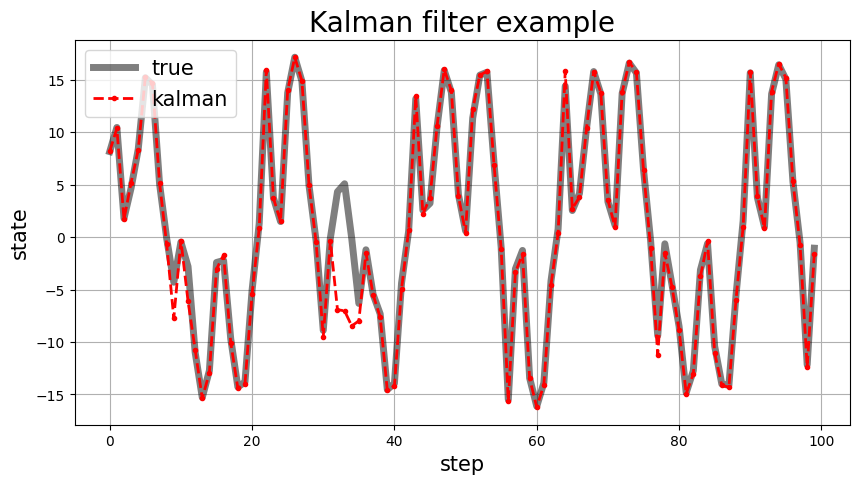

In [153]:
plt.figure(figsize=[10, 5], facecolor='w')
plt.plot(x_true_list, 'k-', linewidth=5, alpha=0.5)
plt.plot(x_list, 'r.--', linewidth=2)
plt.grid('on')
plt.xlabel('step', fontsize=15)
plt.ylabel('state', fontsize=15)
plt.title('Kalman filter example', fontsize=20)
plt.legend(['true', 'kalman'], fontsize=15)
plt.show()

# **EKF SLAM in 2D SPACE**
### **OBJECTIVE**
- Extended Kalman filter를 이용해 맵 정보와 로봇의 path를 구하는 것
- **Given**: 
  1. Robot controls: 로봇의 제어입력
  2. Observations: 로봇에서 관측한 환경 정보
- **Wanted**:
  1. 로봇이 있는 환경의 맵 정보
  2. 로봇이 지나온 궤적

### **Data format**
- world: landmark(map)의 index와 2d position (idx, x, y)
- sensor: 로봇이 측정한 센서의 index와 2d position (time, idx, x, y)

    idx의 차원은 센서가 측정한 landamark의 개수에 따라서 가변적
- odom: 로봇의 control input (time, δ_rot1, δ_trans, δ_rot2)

### **Robot motion model**

**states**
- 2차원에서 robot의 좌표와 각도

**inputs**
- δ_rot1: 첫 번째 회전 입력
- δ_trans: 종방향 이동 거리 입력
- δ_rot2: 두 번째 회전 입력

<img src="./images/figure11.png" width="500px" title="figure11"/>

**motion model**

<img src="./images/figure12.png" width="500px" title="figure12"/>

<img src="./images/figure13.png" width="500px" title="figure13"/>

### **Import modules**

In [154]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
import math

from IPython.display import clear_output
import cv2
import glob
import warnings

### **Initialization**

In [155]:
n = 3 # robot input의 차원
m = 9 # landmark의 개수
dim = n + 2*m # robot input (n) + landmark position (2*m)

P = np.eye(dim)
P[:n, :n] = 1e-5 

R = np.diag([0.1, 0.1, 0.01]) # x, y, theta model에 관한 uncertainty
Q = np.diag([10, 1]*m) # sensor에 관한 uncertainty

flag = np.zeros(9) # landmark가 측정되었는지에 관한 flag

### **world (map)**
- landmark들의 index와 위치로 구성
- shape: (num_landmark, x, y)


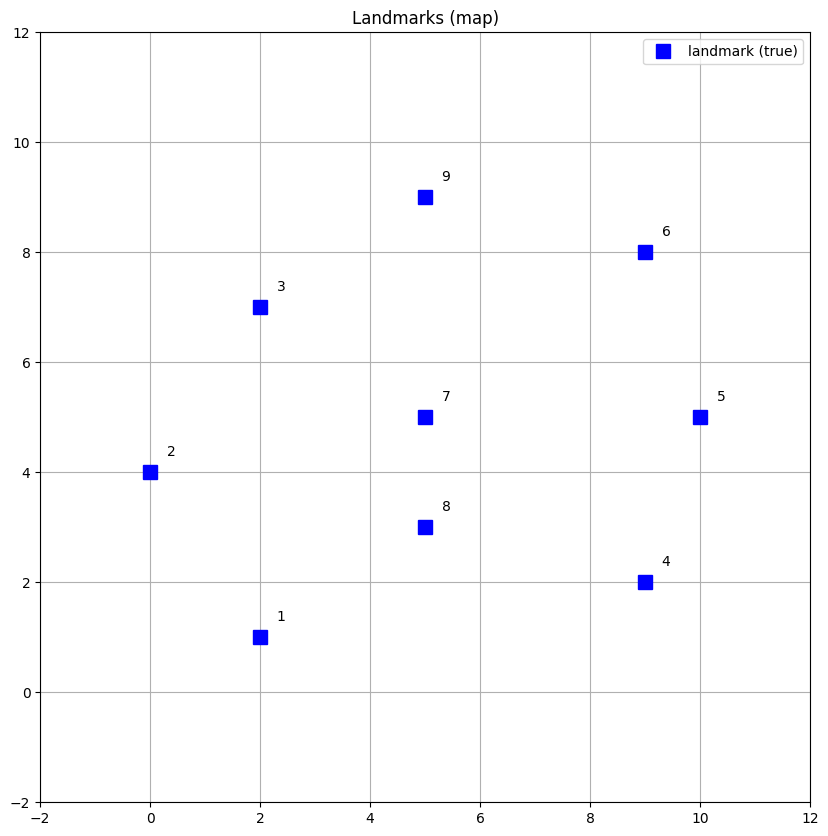

In [156]:
# load world data: map에 관한 정보가 저장되어있는 world.dat 가져오기
world = np.loadtxt('./world.dat') # google drive에 저장한 위치 입력

plt.figure(figsize=[10,10])
# landmark의 x, y 위치 plot
plt.plot(world[:,1], world[:,2], 'bs', markersize=10)
plt.grid('on')
plt.axis('scaled')
plt.title('Landmarks (map)')

# landmark의 index plot
for i in range(len(world)):
    plt.text(world[i,1]+0.3, world[i,2]+0.3, str(int(world[i,0])))
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.legend(['landmark (true)'])
plt.show()

### **sensor**
- odom: robot의 motion input을 저장
- sensor: 로봇에서 측정한 landmark의 r, phi 저장


In [157]:
sensor = []
odom = []
temp = []
save = False
with open('./sensor_data.dat') as f:
    lines = f.readlines()
    i = 0
    for line in lines:
        line = line.replace('\n','')
        if 'ODOMETRY' in line:
            line = line.replace('ODOMETRY ', '')
            if save == False:
                save = True
                line = line.split(' ')
                line = np.array(line)
                line = line.astype(np.float)
                odom.append(line)
            else:
                save = False
                sensor.append(temp)
                temp = []
                line = line.split(' ')
                line = np.array(line)
                line = line.astype(np.float)
                odom.append(line)
                save = True
        else:
            line = line.replace('SENSOR ', '')
            line = line.split(' ')
            line = np.array(line)
            line = line.astype(np.float)
            temp.append(line)
        if i == (len(lines) - 1):
            sensor.append(np.array(temp))
        i += 1

odom = np.array(odom)
sensor = np.array(sensor)

print("odometry sensor data shape at 330s:",odom[-1].shape)
print("observation sensor data shape at 330s:", np.shape(sensor[-1]))
print("")

odometry sensor data shape at 330s: (3,)
observation sensor data shape at 330s: (7, 3)



C:\Users\dsa35\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:38: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


### **Robot motion**
- 로봇이 맵 상에서 대략적으로 어떻게 움직였는지 확인

<img src="./images/figure14.png" width="500px" title="figure14"/>

In [158]:
# robot motion을 업데이트 할 때, [-pi, pi]의 범위를 넘지 않도록 변환시켜줄 필요가 있음
# robot의 각도를 [-pi, pi] 범위로 변환하기 위한 함수
def norm_rot(theta):
    theta = math.atan2(math.sin(theta), math.cos(theta))
    return theta

In [159]:
def motion_model(x, odom):
    theta = x[2,0]
    
    d_rot1 = odom[0]
    d_trans = odom[1]
    d_rot2 = odom[2]

    # robot motion model
    ########### TODO: robot motion model 작성 ###########
    # g = np.zeros([3,1])
    g=np.array([[d_trans*math.cos(theta+d_rot1)],
                [d_trans*math.sin(theta+d_rot1)],
                [d_rot1+d_rot2]])
    ####################################################
    
    x_pred = x + g
    # 각도 범위 제한
    x_pred[2,0] = norm_rot(x_pred[2,0])
    return x_pred

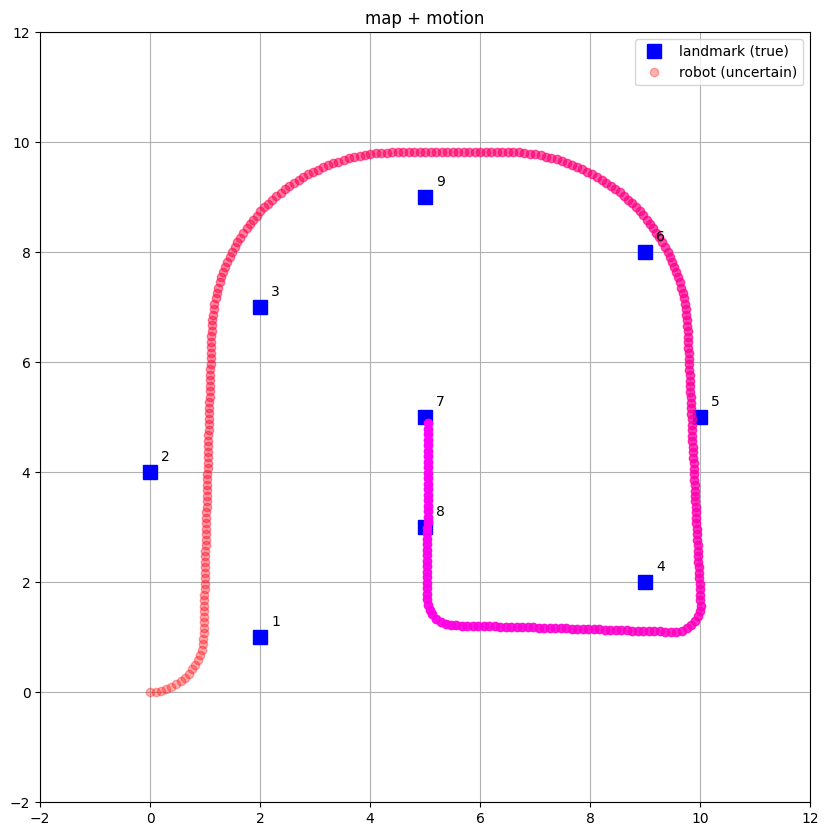

In [160]:
# robot이 어떤 궤적을 그리고 움직였는지 plot
# input data 만을 이용하여 궤적을 그렸기 때문에 실제 움직인 경로와는 차이가 존재

x = np.zeros([3,1]) # 초기 state 정의
motion_update_list = []
motion_update_list.append(x)

for i in range(len(odom)):
    x = motion_model(x, odom[i]) # motion update
    motion_update_list.append(x)

motion_update_list = np.array(motion_update_list)

# world(map) plot
plt.figure(figsize=[10,10])
plt.plot(world[:,1], world[:,2], 'bs', markersize=10)
plt.grid('on')
plt.title('map + motion')
for i in range(len(world)):
    plt.text(world[i,1]+0.2, world[i,2]+0.2, str(int(world[i,0])))

# robot trajectory plot
color = np.linspace([1, 0, 0, 0.3], [1, 0, 1, 1], len(motion_update_list))
for i in range(len(motion_update_list)):
    plt.plot(motion_update_list[i,0], motion_update_list[i,1], 'o', color=color[i])
plt.axis('scaled')
plt.legend(['landmark (true)', 'robot (uncertain)'])
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.show()

### **Sensor model**
- Range Bearing model

<img src="./images/figure15.png" width="500px" title="figure15"/>

<img src="./images/figure16.png" width="500px" title="figure16"/>

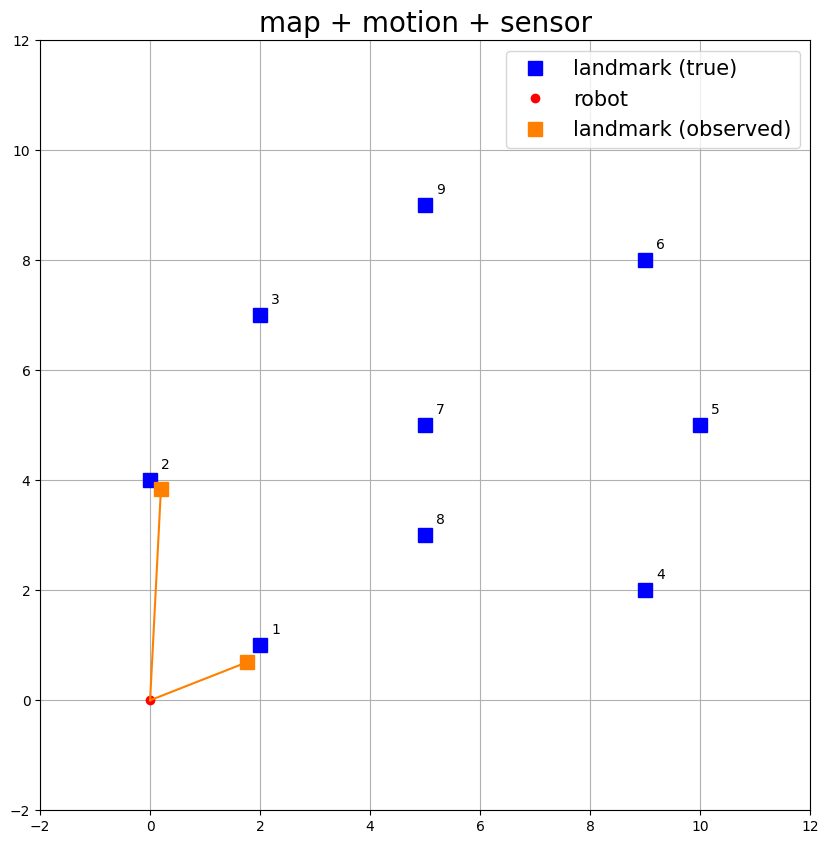

In [161]:
# sensor가 어떻게 측정되었는지 확인
x = np.zeros([3,1]) # 초기 로봇 state 정의
sensor_example = sensor[0]
landmark_pos = []
z_list = []
for i in range(len(sensor_example)):
    # robot이 측정한 센서값 정의
    index = sensor_example[i][0]
    r = sensor_example[i][1]
    phi = sensor_example[i][2]
    
    ##### TODO: 센서로 부터 landmark의 위치 정의 #####
    temp_x = x[0, 0]+r*math.cos(phi+x[2,0])
    temp_y = x[1, 0]+r*math.sin(phi+x[2,0])
    #############################################

    landmark_pos.append(np.array([[temp_x], [temp_y]]))

landmark_pos = np.array(landmark_pos)

# map 플랏
plt.figure(figsize=[10,10])
plt.plot(world[:,1], world[:,2], 'bs', markersize=10)
plt.grid('on')
plt.title('map + motion + sensor', fontsize=20)
for i in range(len(world)):
    plt.text(world[i,1]+0.2, world[i,2]+0.2, str(int(world[i,0])))
plt.plot(x[0,0],  x[1,0], 'ro')

# 측정한 센서값 플랏
plt.plot(landmark_pos[:,0], landmark_pos[:, 1], 's', color=[1, 0.5, 0], markersize=10)
for i in range(len(landmark_pos)):
    plt.plot([x[0,0], landmark_pos[i,0]], [x[1,0], landmark_pos[i,1]], color=[1, 0.5, 0],)

plt.axis('scaled')
plt.legend(['landmark (true)', 'robot', 'landmark (observed)'], fontsize=15, loc='upper right')
plt.xlim([-2, 12])
plt.ylim([-2, 12])
plt.show()

## **EKF**

### **Prediction**
- Extended Kalman Filter의 예측 부분을 작성
- state의 차원이 (n+2*m) 이지만 로봇 모션은 n차원까지만 영향을 
끼침
- 계산의 편의성을 위해 matrix F (n x (n + 2m))를 정의

<img src="./images/figure17.png" width="500px" title="figure17"/>

<img src="./images/figure18.png" width="500px" title="figure18"/>

- motion model을 미분한 값

<img src="./images/figure21.png" width="500px" title="figure21"/>

<img src="./images/figure19.png" width="500px" title="figure19"/>

In [162]:
def prediction(x, u, P, R):
    # robot의 input을 통해 motion update
    theta = x[2, 0]
    
    d_rot1 = u[0]
    d_trans = u[1]
    d_rot2 = u[2]
    F = np.zeros([n, dim])
    F[:n, :n] = np.eye(n)
    
    ########### TODO: robot motion model 정의 및 state update ###########
    g=np.array([[d_trans*math.cos(theta+d_rot1)],
                [d_trans*math.sin(theta+d_rot1)],
                [d_rot1+d_rot2]])
                
    # Hint: F matrix를 이용하여 차원 변환
    x_p = x+(F.T@g)
    x_p[2, 0] = norm_rot(x_p[2, 0])
    ###################################################################    
    
    ########### TODO: motion model jacobian matrix 정의 및 covariance update ###########
    G = np.eye(dim) #21x21
    G[0,2]=-d_trans*math.sin(theta+d_rot1)
    G[1,2]=d_trans*math.cos(theta+d_rot1)
    # Hint: motion model에 대한 covariance인 R[3x3]을 state 크기만큼 확장해줘야 차원이 맞음
    R_aug = np.zeros([dim,dim])
    R_aug[0:3,0:3] = R #21x21
    P_p = G@P@G.T+R_aug
    
    ###################################################################################
    
    return x_p, P_p

### **Correction**
- 센서가 landmark에 대해 측정할 때, 어떤 index를 가지고 있는지는 안다고 가정 (association이 되어있다 가정)
- sensor에서 여러개의 landmark에 대한 정보가 들어오기때문에 각각에 대한 correction 필요
- 이전에 측정되지 않았던 landmark라면 초기화 과정 필요

<img src="./images/figure20.png" width="500px" title="figure20"/>

<img src="./images/figure22.png" width="500px" title="figure22"/>

<img src="./images/figure23.png" width="500px" title="figure23"/>

- 계산의 편의성을 위해 F matrix 정의 [5xN]
- j 번째 landmark를 update하기 위한 matrix

<img src="./images/figure24.png" width="800px" title="figure24"/>


In [163]:
def correction(x, sensor, P, Q, flag):
    y = np.zeros([2*m, 1])
    H = np.zeros([2*m, dim])
    # 각각의 랜드마크에 대한 correction 필요
    for i in range(len(sensor)):
        idx = int(sensor[i][0]) - 1 # landmark의 index
        r = sensor[i][1] # robot과 landmark 간 거리
        phi = sensor[i][2] # robot과 landmark 사이 각도
        z = np.array([[r],[phi]])
        if flag[idx] == 0:
            ############### TODO: landmark 초기화 ###############
            # flag가 0이면 처음 보는 랜드마크, 이후에는 flag를 1로 변환
            # 이전에 측정되지 않은 랜드마크라면 초기화과정 필요
            # 2*idx + 3: sensor의 x 위치
            # 2*idx + 4: sensor의 y 위치
            x[2*idx + 3, 0] = x[0, 0]+r*math.cos(phi+x[2,0])
            x[2*idx + 4, 0] = x[1, 0]+r*math.sin(phi+x[2,0])
            flag[idx] = 1 
            ###################################################
        
        # else:
        #     x[2*idx + 3, 0] = x[0, 0]+r*math.cos(phi+x[2,0])
        #     x[2*idx + 4, 0] = x[1, 0]+r*math.sin(phi+x[2,0])
        
        ################# TODO: sensor model 정의 #################
        d=np.array([[x[2*idx+3,0]-x[0,0]],[x[2*idx+4,0]-x[1,0]]])
        q = d.T@d
        h=np.array([[np.sqrt(q)],
                    [math.atan2(d[1,0],d[0,0])-x[2,0]]])
        ###########################################################
        e = np.zeros([2*m,1])
        e[2*idx:2*idx+2,0:1] = z - h
        e[2*idx+1, 0:1] = norm_rot(e[2*idx+1,0:1])
        ###################### TODO: F matrix 정의 ######################
        F = np.zeros([5, dim])
        F[0:3,0:3]=np.eye(3)
        F[3:5,2*idx+2:2*idx+4]=np.eye(2)
        ################################################################
    
        ###################### TODO: sensor model jacobian matrix 정의 ######################
        H_x = 1/q*(np.array([[-np.sqrt(q)*d[0,0],-np.sqrt(q)*d[1,0],0,np.sqrt(q)*d[0,0],np.sqrt(q)*d[1,0]],
                            [d[1,0],-d[0,0],-q,-d[1,0],d[0,0]]]))
        H[2*idx:2*idx+2, :] = H_x @ F
        ####################################################################################
    
    ############# TODO: correction step 작성 #############
    # K = np.zeros([N, 5])
    K = P@H.T@np.linalg.inv(H@P@H.T+Q)
    print(K@e)
    x_c = x + K@e
    x_c[2, 0] = norm_rot(x_c[2, 0])
    P_c = (np.eye(len(K@H))-K@H)@P
    ####################################################
    
    return x_c, P_c, flag
        

In [164]:
def ellipse(cov, x, y, color):
    w, v =np.linalg.eig(cov)
    t = np.linspace(0, 2*np.pi, 50)
    p90 = 1
    xx = (v[0,0]*np.sqrt(w[0])*np.cos(t) + v[0,1]*np.sqrt(w[1])*np.sin(t)) * 2 * np.sqrt(p90) + x
    yy = (v[1,0]*np.sqrt(w[0])*np.cos(t) + v[1,1]*np.sqrt(w[1])*np.sin(t)) * 2 * np.sqrt(p90) + y
    plt.plot(xx, yy, '--', color=color)

In [165]:
# Extend Kalman filter
x = np.zeros([dim, 1])

flag = np.zeros(9)

for i in range(330):
    x, P = prediction(x, odom[i], P, R)
    x, P, flag = correction(x, sensor[i], P, Q, flag)
    robot_x = x[0,0]
    robot_y = x[1,0]
    plt.figure(figsize=[10, 10])
    # ture map plot
    plt.plot(world[:,1], world[:,2], 'b s', markersize=10)
    ############ TODO: tilte에 학번 이름 작성 ################
    plt.title('EKF SLAM in 2D space, 2022109744, ParkGeonYeong')

    map_x = []
    map_y = []
    map_P = []
    for j in range(m):
        if flag[j] == 1:
            map_x.append(x[2*j+3,0])
            map_y.append(x[2*j+4,0])
            map_P.append(P[2*j+3:2*j+5, 2*j+3:2*j+5])
    # estimated map plot
    plt.plot(map_x, map_y, 's', color=[1, 0.5, 0], markersize=10)
    # robot position plot
    plt.plot(robot_x, robot_y, 'r o', markersize=10)
    # robot의 uncertainty plot
    ellipse(P[:2,:2], x[0,0], x[1,0], 'r')
    # map의 uncertainty plot
    for k in range(len(map_x)):
        ellipse(map_P[k], map_x[k], map_y[k], [1, 0.5, 0],)
    # robot이 측정한 landmark가 무엇인지 연결
    for p in range(len(sensor[i])):
        num = int(sensor[i][p][0]) - 1
        plt.plot([robot_x, x[3+2*num,0]], [robot_y, x[4+2*num, 0]], color=[1, 0.5, 0])
        
    plt.axis([-2, 12, -2, 12])
    plt.grid('on')
    plt.legend(['landmark (true)', 'landmark (estimated)', 'robot (estimated)'], fontsize=15, loc='upper right')
    # plt.pause(0.1)
    # plt.show()
    # 이미지가 저장된 폴더 입력
    plt.savefig('./figures/fig'+str(f'{i:03}')+'.png', dpi=300)
    plt.close()

C:\Users\dsa35\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:29: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
C:\Users\dsa35\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:42: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


[[-1.73846909e-19]
 [ 3.92062013e-18]
 [-1.68696823e-20]
 [ 7.63704853e-19]
 [ 1.98843393e-18]
 [-3.99655460e-17]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]
 [ 0.00000000e+00]]
[[-0.00202539]
 [-0.00143858]
 [ 0.00082525]
 [ 0.00025614]
 [ 0.01025705]
 [ 0.0067864 ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]]
[[-0.00745691]
 [-0.00518155]
 [ 0.00308224]
 [ 0.00115113]
 [ 0.02515046]
 [ 0.01539834]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]
 [ 0.        ]

## 동영상 만드는 코드
- figure 폴더에 저장된 사진을 동영상으로 변환

In [166]:
img_array = []
# 이미지가 저장된 폴더 입력
for filename in sorted(glob.glob('./figures/*.png')):
    img = cv2.imread(filename)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)

# 결과물로 제출할 동영상 파일명 입력
out = cv2.VideoWriter('./EKF_SLAM.mp4',cv2.VideoWriter_fourcc(*'DIVX'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()